In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from keras.preprocessing import image as Kimage
from keras.utils import np_utils
from keras.applications.xception import Xception, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint  
from keras import optimizers

from tqdm import tqdm
import pydicom
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
print(os.listdir("../input"))
import keras

['kernelf61b8ae5a8', 'rsna-pneumonia-detection-challenge']


In [4]:
model_type = 'FC1024'
dropout = 0.2
optimizer_type = 'Adam'
learning_rate = 1e-4
Augmentation_Indicator = False
epochs = 20
batch_size = 8
transfer_learning = True
random_state = 1607

In [5]:
# Load train labels
input_data = pd.read_csv("../input/kernelf61b8ae5a8/data.csv")
input_data['img_path'] = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/' + input_data['patientId'] + '.dcm'

In [6]:
print(os.listdir("../input/rsna-pneumonia-detection-challenge"))

['stage_2_detailed_class_info.csv', 'stage_2_train_labels.csv', 'stage_2_sample_submission.csv', 'stage_2_test_images', 'GCP Credits Request Link - RSNA.txt', 'stage_2_train_images']


In [7]:
input_data.head()

,Unnamed: 0,patientId,Target,class,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing,img_path
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,No Lung Opacity / Not Normal,CR,51,F,CHEST,PA,WSD,1024,1024,0.143,../input/rsna-pneumonia-detection-challenge/st...
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,No Lung Opacity / Not Normal,CR,48,F,CHEST,PA,WSD,1024,1024,0.194,../input/rsna-pneumonia-detection-challenge/st...
2,2,00322d4d-1c29-4943-afc9-b6754be640eb,0,No Lung Opacity / Not Normal,CR,19,M,CHEST,AP,WSD,1024,1024,0.168,../input/rsna-pneumonia-detection-challenge/st...
3,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,Normal,CR,28,M,CHEST,PA,WSD,1024,1024,0.143,../input/rsna-pneumonia-detection-challenge/st...
4,4,00436515-870c-4b36-a041-de91049b9ab4,1,Lung Opacity,CR,32,F,CHEST,AP,WSD,1024,1024,0.139,../input/rsna-pneumonia-detection-challenge/st...


In [8]:
input_data = input_data.drop(['Unnamed: 0', 'Modality', 'BodyPartExamined', 'ViewPosition', 'ConversionType',
       'Rows', 'Columns', 'PixelSpacing'], axis = 1)

In [9]:
input_data.dtypes

patientId     object
Target         int64
class         object
PatientAge     int64
PatientSex    object
img_path      object
dtype: object

In [10]:
# Convert class into categorical variable
input_data['class'] = pd.Categorical(input_data['class'])
input_data['target'] = input_data['class'].cat.codes

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
input_data['class'] = label_encoder.fit_transform(input_data['class'])

In [12]:
input_data.head()

,patientId,Target,class,PatientAge,PatientSex,img_path,target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,1,51,F,../input/rsna-pneumonia-detection-challenge/st...,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,1,48,F,../input/rsna-pneumonia-detection-challenge/st...,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,1,19,M,../input/rsna-pneumonia-detection-challenge/st...,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,2,28,M,../input/rsna-pneumonia-detection-challenge/st...,2
4,00436515-870c-4b36-a041-de91049b9ab4,1,0,32,F,../input/rsna-pneumonia-detection-challenge/st...,0


In [13]:
remove, input_data  = train_test_split(input_data, 
                                test_size=0.03, 
                                random_state=random_state,
                                stratify=input_data['class'])

In [14]:
print('Total images taken: {}'.format(input_data.shape[0]))
input_data.head()

Total images taken: 801


,patientId,Target,class,PatientAge,PatientSex,img_path,target
18962,c5e3881b-9b54-453a-8761-4c2f88978616,0,1,33,M,../input/rsna-pneumonia-detection-challenge/st...,1
12640,8dd9cf58-1874-4592-b5aa-f5fd962337fd,1,0,50,F,../input/rsna-pneumonia-detection-challenge/st...,0
9825,74b3eae5-6d97-4d52-ab1c-20d9be51b413,0,2,65,F,../input/rsna-pneumonia-detection-challenge/st...,2
15090,a378eddb-1629-4d23-a4ca-e13abb065a77,0,1,47,M,../input/rsna-pneumonia-detection-challenge/st...,1
6907,5c362c0e-dab1-4a4a-80c2-eca48c7c0dd0,0,2,41,M,../input/rsna-pneumonia-detection-challenge/st...,2


In [15]:
# Split train and test images
train, test = train_test_split(input_data, 
                                test_size=0.20, 
                                random_state=random_state,
                                stratify=input_data['class'])

# Split train and validation images
train, valid = train_test_split(train, 
                                test_size=0.20, 
                                random_state=random_state,
                                stratify=train['class'])

print('Total train images taken: {}'.format(train.shape[0]))
print('Total validation images taken: {}'.format(valid.shape[0]))
print('Total test images taken: {}'.format(test.shape[0]))

Total train images taken: 512
Total validation images taken: 128
Total test images taken: 161


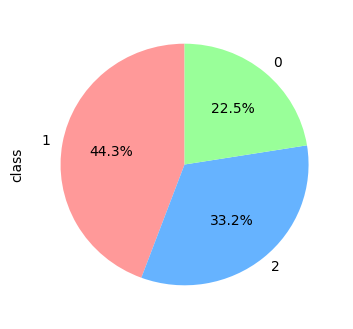

In [16]:
# Show the class balance in train images
fig = plt.figure(figsize=(4,4), dpi=100)
ax = plt.subplot(111)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
train['class'].value_counts().plot(kind='pie', ax=ax, autopct='%1.1f%%', 
                                   startangle=90, fontsize=10, colors = colors)
plt.show()

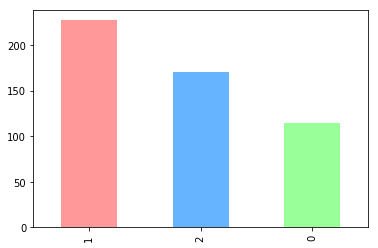

In [17]:
ax = plt.subplot(111)
train['class'].value_counts().plot(kind='bar', ax=ax, color=colors)
plt.show()

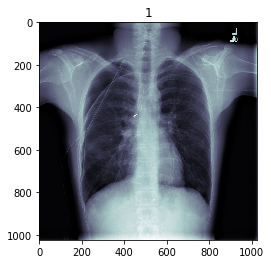

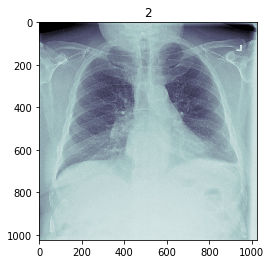

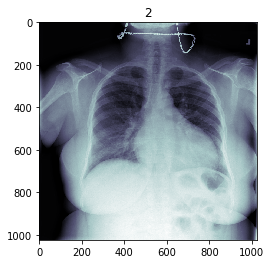

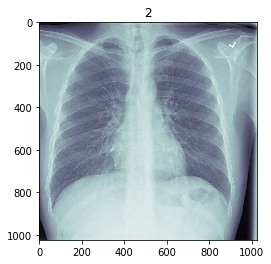

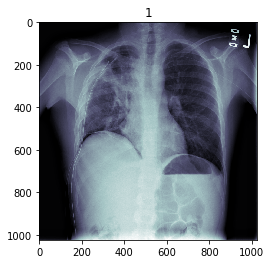

In [18]:
for i, row in enumerate(train.head().values):
    image_name = row[0]
    pneumonia_class = row[2]
    image_path = row[5]
    ds = pydicom.dcmread(image_path)
    plt.figure()
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    plt.title(pneumonia_class)

In [19]:
def load_dicom_image(img_path):
    img_arr = pydicom.read_file(img_path).pixel_array
    img_arr = img_arr/img_arr.max()
    slice_value = (255*img_arr).clip(0, 255).astype(np.uint8)
    img = Image.fromarray(slice_value)
    Kimage.pil_image = img
    return Kimage.pil_image

# Convert 3D tensors to 4D tensors where each 4D tensor is a different image
def path_to_tensor(img_path):
    # Read the dcm image using pydicom
    img = load_dicom_image(img_path)
    # convert PIL.Image.Image type to 3D tensor
    x = Kimage.img_to_array(img)
    # Since it is a grayscale image convert into three channels
    x = np.squeeze(np.repeat(x[:, :, np.newaxis], 3, axis=2), axis=3)
    # convert 3D tensor to 4D tensor with shape and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [preprocess_input(path_to_tensor(img_path)) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [20]:
# Load all the tensors and re-scale the data
train_tensors = paths_to_tensor(train['img_path'])
valid_tensors = paths_to_tensor(valid['img_path'])
test_tensors = paths_to_tensor(test['img_path'])

100%|██████████| 161/161 [00:08<00:00, 17.12it/s]


In [21]:
# Load all the targets
train_targets = np_utils.to_categorical(np.array(train['class']), 3)
valid_targets = np_utils.to_categorical(np.array(valid['class']), 3)
test_targets = np_utils.to_categorical(np.array(test['class']), 3)

In [22]:
test_tensors.shape

(161, 1024, 1024, 3)

In [23]:
input_shape=(1024, 1024, 3)

In [24]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(dropout))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='tanh'))
model.add(Dropout(dropout))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(dropout))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(dropout))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1024, 1024, 16)    208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 512, 512, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 32)      2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512, 512, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 64)      8256      
__________

In [28]:
# Compile the model
if optimizer_type == 'SGD':
    optimizer=optimizers.SGD(lr=learning_rate, momentum=0.9)
elif optimizer_type == 'Adam':
    optimizer = optimizers.Adam(lr=learning_rate)
else:
    optimizer = optimizers.RMSprop()
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [29]:
# create and configure augmented image generator
datagen_train = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

MemoryError: 

In [30]:
model.fit(train_tensors, train_targets,
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=batch_size, verbose=1)

Train on 512 samples, validate on 128 samples
Epoch 1/20
512/512 [==============================] - 41s 80ms/step - loss: 1.0712 - categorical_accuracy: 0.4395 - val_loss: 1.0693 - val_categorical_accuracy: 0.4453
Epoch 2/20
512/512 [==============================] - 35s 69ms/step - loss: 1.0593 - categorical_accuracy: 0.4434 - val_loss: 1.0679 - val_categorical_accuracy: 0.4453
Epoch 3/20
512/512 [==============================] - 36s 70ms/step - loss: 1.0583 - categorical_accuracy: 0.4434 - val_loss: 1.0709 - val_categorical_accuracy: 0.4453
Epoch 4/20
512/512 [==============================] - 36s 70ms/step - loss: 1.0567 - categorical_accuracy: 0.4434 - val_loss: 1.0681 - val_categorical_accuracy: 0.4453
Epoch 5/20
512/512 [==============================] - 36s 70ms/step - loss: 1.0564 - categorical_accuracy: 0.4434 - val_loss: 1.0690 - val_categorical_accuracy: 0.4453
Epoch 6/20
512/512 [==============================] - 36s 70ms/step - loss: 1.0557 - categorical_accuracy: 0.4434 

In [ ]:
# get index of predicted value for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)